<a href="https://colab.research.google.com/github/dogukartal/ML-RoadMap/blob/main/Diffusion/Hugging%20Face/2_2_DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## UNet2DModel
---
The UNet2DModel is a bit more advanced than the BasicUNet. The corruption process and the training objective is different. The objective is the predcting the noise rather than the image.

In [ ]:
%pip install -q diffusers

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())  #FashionMNIST

In [2]:
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)

print("Number of the parameters: ", sum([p.numel() for p in net.parameters()]))

Number of the parameters:  1707009


Finished epoch 0. Average loss for this epoch: 0.018753
Finished epoch 1. Average loss for this epoch: 0.012587
Finished epoch 2. Average loss for this epoch: 0.011575


Text(0.5, 1.0, 'Generated Samples')

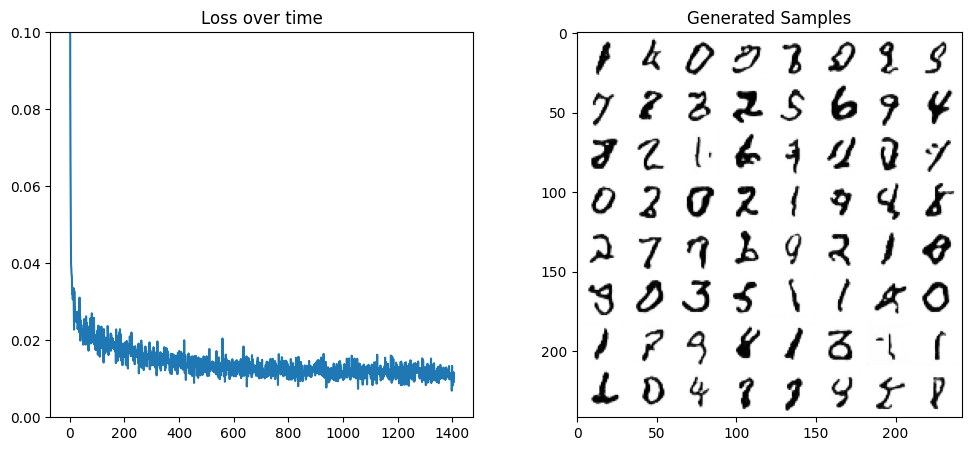

In [3]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return x * (1 - amount) + noise * amount

n_epochs = 3
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

net.to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []

for epoch in range(n_epochs):
    for x, y in train_dataloader:
        # Get some data and prepare the corrupted version
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        # Get the model prediction
        pred = net(noisy_x, 0).sample  # <<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x)

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps))  # Starting high going low
    with torch.no_grad():
        pred = net(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Generated Samples")

## The Corruption Process
---
The DDPM paper describes a corruption process that adds a small amount of noise for every ‘timestep’. Given $x_{t-1}$ for some timestep, we can get the next (slightly more noisy) version $x_t$ with:


$q(\mathbf{x}t \vert \mathbf{x}{t-1}) = \mathcal{N}(\mathbf{x}t; \sqrt{1 - \beta_t} \mathbf{x}{t-1}, \beta\mathbf{I}) \quad q(\mathbf{x}{1:T} \vert \mathbf{x}0) = \prod^T{t=1} q(\mathbf{x}t \vert \mathbf{x}{t-1})$


That is, we take $x{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\beta_t$. This $\beta$ is defined for every t according to some schedule, and determines how much noise is added per timestep. Now, we don’t necessarily want to do this operation 500 times to get $x{500}$ so we have another formula to get $x_t$ for any t given $x_0$:


$\begin{aligned} q(\mathbf{x}t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, \sqrt{(1 - \bar{\alpha}_t)} \mathbf{I}) \end{aligned}$ where $\bar{\alpha}_t = \prod{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$


The maths notation always looks scary! Luckily the scheduler handles all that for us (uncomment the next cell to check out the code). We can plot $\sqrt{\bar{\alpha}_t}$ (labelled as sqrt_alpha_prod) and $\sqrt{(1 - \bar{\alpha}_t)}$ (labelled as sqrt_one_minus_alpha_prod) to view how the input (x) and the noise are scaled and mixed across different timesteps. Initially, the noisy x is mostly x (${\sqrt{\bar{\alpha}_t}}$ ~= 1) but over time the contribution of x drops and the noise component increases.

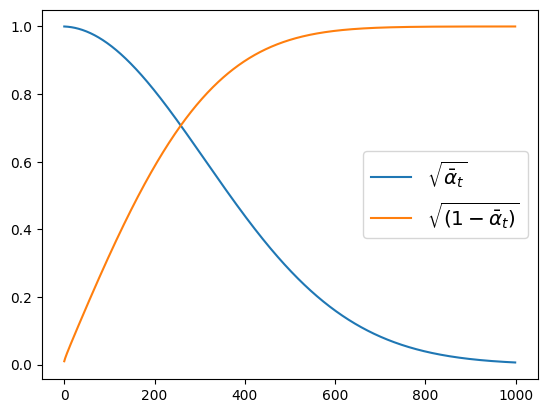

In [4]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


Text(0.5, 1.0, 'Noisy X')

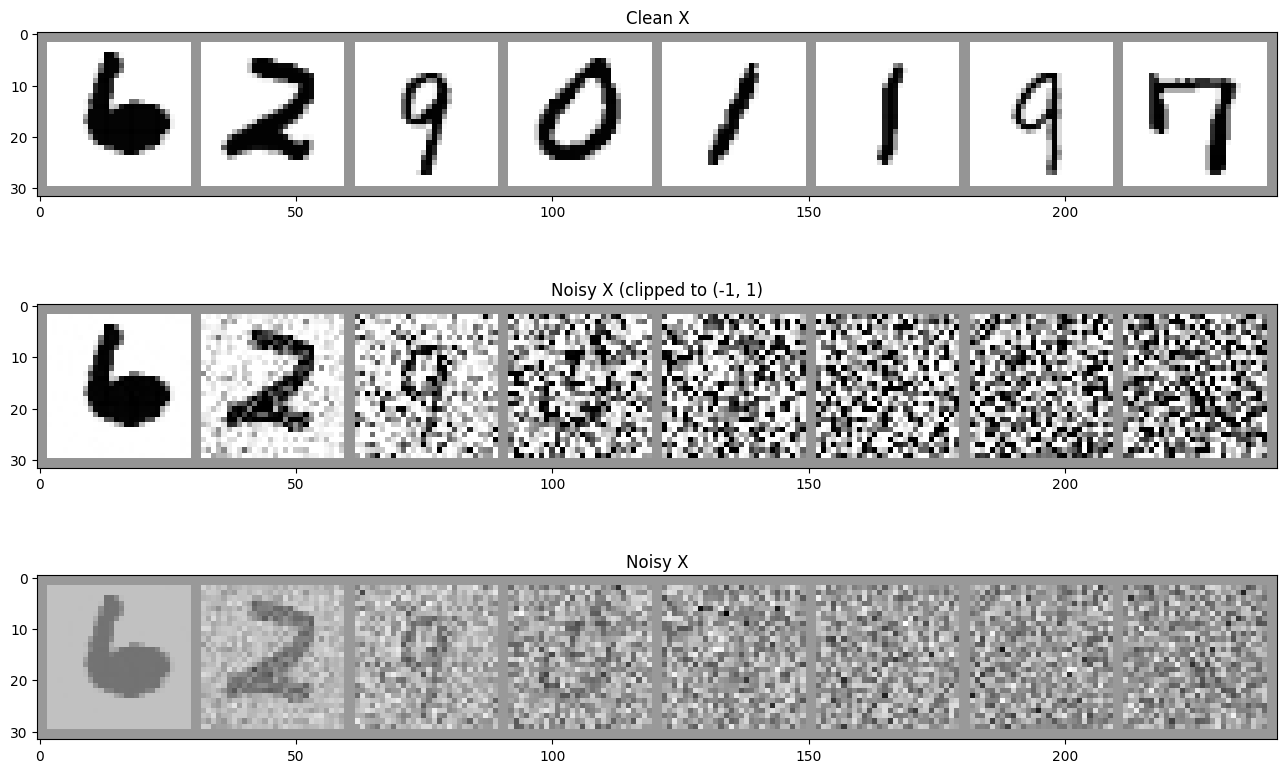

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2.0 - 1.0  # Map to (-1, 1)
print("X shape", xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap="Greys")
axs[0].set_title("Clean X")

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)  # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1), cmap="Greys")
axs[1].set_title("Noisy X (clipped to (-1, 1)")
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(), cmap="Greys")
axs[2].set_title("Noisy X")